In [1]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sms
import seaborn as sns
from scipy.stats import chisquare
from shapely.geometry import Point

In [2]:
#specify relevant columns for fires dataset
columns=['CalYear', 'PropertyCategory', 'IncGeo_WardCode', 'IncidentGroup', 'Easting_rounded', 'Northing_rounded']

In [3]:
#load csv files while filtering only 2021 incidents 

chunksize = 10000  # tamaño del fragmento
fires = []

for chunk in pd.read_csv("fires.csv", usecols=columns, chunksize=chunksize):
    # Filtrar filas con CalYear == 2021
    fires.append(chunk[chunk["CalYear"] == 2021])

#Concatenate all chunks
fires= pd.concat(fires)

In [4]:
#filter only incidents on dwellings
fires = fires[(fires.PropertyCategory == "Dwelling") & (fires.IncidentGroup == "Fire")]

In [5]:
fires = fires.drop(["PropertyCategory", "IncidentGroup"], axis=1)


In [6]:
len(fires)

4914

In [7]:
fires.head(10)

,CalYear,IncGeo_WardCode,Easting_rounded,Northing_rounded
309557,2021,E05013536,520050,179850
309558,2021,E05014111,530350,176350
309607,2021,E05014009,527950,173950
309609,2021,E05013792,526350,182550
309615,2021,E05013793,525750,181450
309626,2021,E05013781,512450,173250
309667,2021,E05013558,513850,186850
309671,2021,E05011232,547850,179150
309678,2021,E05014019,528250,176050
309680,2021,E05011476,531850,160950


,WD24CD,WD24NM,LAD24CD,LAD24NM,geometry
1104,E05009288,Aldersgate,E09000001,City of London,"POLYGON ((532248.702 181560.298, 532245.099 18..."
1105,E05009289,Aldgate,E09000001,City of London,"POLYGON ((533466.102 181405.602, 533471.198 18..."
1106,E05009290,Bassishaw,E09000001,City of London,"POLYGON ((532536.199 181632.598, 532544.799 18..."
1107,E05009291,Billingsgate,E09000001,City of London,"POLYGON ((533320.917 180540.258, 533318.838 18..."
1108,E05009292,Bishopsgate,E09000001,City of London,"POLYGON ((533404.869 182037.77, 533404.919 182..."


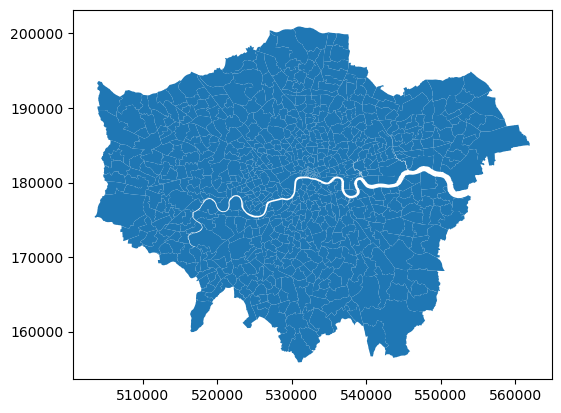

In [8]:
columns=["WD24CD","WD24NM","LAD24CD","LAD24NM", "geometry"]

#Load UK's wards boundaries
wards = gpd.read_file("WD_DEC_24_UK_BFC.shp")[columns]

#Filter only wards corresponding to London
london_wards=wards[wards['LAD24CD'].str.contains("E09", na=False)]

london_wards.plot()
london_wards.head()

I plan to aggregate ward's socio-economic profiles, which include all wards within City of London as one ward. Because of that, I'll merge all those wards in one with code E0900001, corresponding to its borough code.

In [9]:
city_of_london_wards=london_wards[london_wards["LAD24CD"]=="E09000001"]
city_of_london_wards=city_of_london_wards.dissolve(by="LAD24CD", as_index=False)

city_of_london_wards.loc[city_of_london_wards['LAD24CD']=="E09000001", ["WD24CD", "WD24NM"]]= ["E09000001", "City of London"]

other_wards=london_wards[london_wards["LAD24CD"]!="E09000001"]
london_wards=pd.concat([city_of_london_wards, other_wards], ignore_index=True)

print(london_wards)

       LAD24CD                                           geometry     WD24CD  \
0    E09000001  MULTIPOLYGON (((531663.092 180546.577, 531662....  E09000001   
1    E09000030  POLYGON ((536274.997 182418.503, 536260.304 18...  E05009317   
2    E09000030  POLYGON ((538733.449 178771.295, 538716.202 17...  E05009318   
3    E09000030  POLYGON ((537638.7 184578.685, 537638.931 1845...  E05009319   
4    E09000030  POLYGON ((537375.704 182857.797, 537322.598 18...  E05009320   
..         ...                                                ...        ...   
675  E09000022  POLYGON ((530286.651 172684.166, 530287.903 17...  E05014115   
676  E09000022  POLYGON ((530932.87 172130.459, 530940.836 172...  E05014116   
677  E09000022  POLYGON ((530736.649 178729.341, 530731.733 17...  E05014117   
678  E09000022  POLYGON ((531335.168 180527.519, 531336.606 18...  E05014118   
679  E09000022  POLYGON ((532641.226 173067.817, 532648.838 17...  E05014119   

                      WD24NM         LA

In [10]:
geometry = [Point(xy) for xy in zip(fires["Easting_rounded"], fires["Northing_rounded"])]
fires_gdf = gpd.GeoDataFrame(fires, geometry=geometry)


In [11]:
fires_gdf.set_crs(wards.crs, inplace=True)

,CalYear,IncGeo_WardCode,Easting_rounded,Northing_rounded,geometry
309557,2021,E05013536,520050,179850,POINT (520050 179850)
309558,2021,E05014111,530350,176350,POINT (530350 176350)
309607,2021,E05014009,527950,173950,POINT (527950 173950)
309609,2021,E05013792,526350,182550,POINT (526350 182550)
309615,2021,E05013793,525750,181450,POINT (525750 181450)
...,...,...,...,...,...
419007,2021,E05009328,537650,180750,POINT (537650 180750)
419016,2021,E05014081,538350,177650,POINT (538350 177650)
419027,2021,E05014016,527450,174550,POINT (527450 174550)
419060,2021,E05013632,521650,190650,POINT (521650 190650)


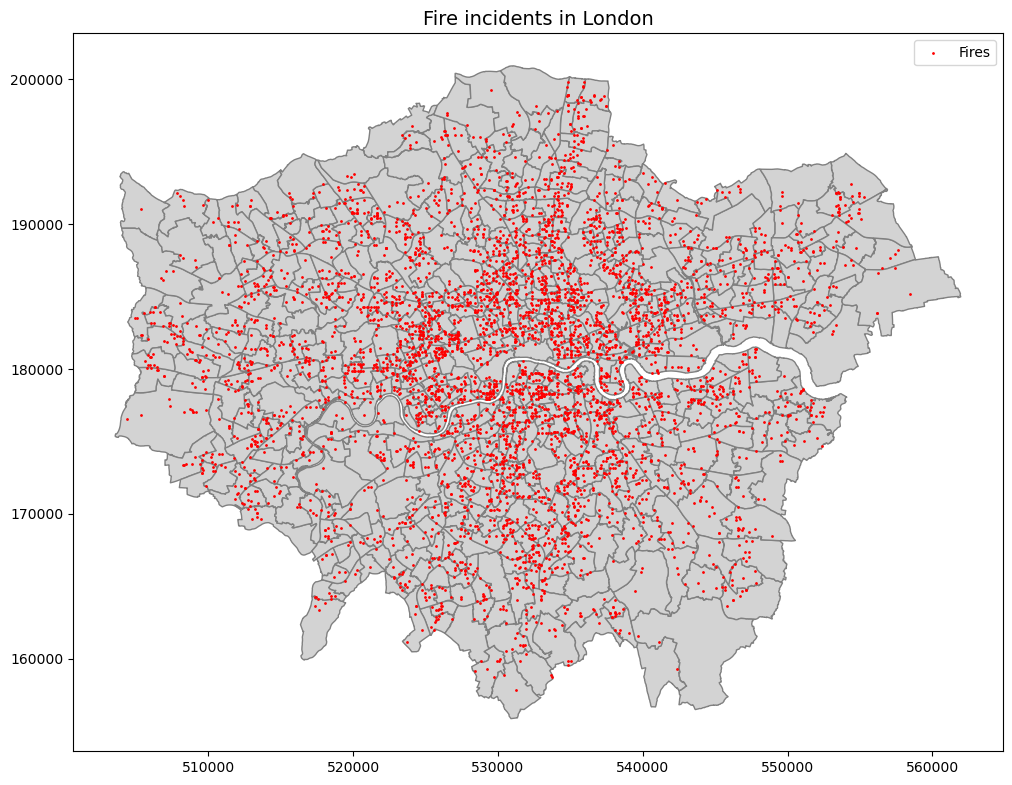

In [12]:
#Set figure
fig, ax = plt.subplots(figsize=(12, 12))

#Plot london wards' shapefile
london_wards.plot(ax=ax, color="lightgrey", edgecolor="grey")

#Plot fire incidents
fires_gdf.plot(ax=ax, color="red", markersize=1, label="Fires")

#Ass info to the graphic
plt.title("Fire incidents in London", fontsize=14)
plt.legend()
plt.show()

Because easting and northing are rounded, it doesn't have enough precision to indicate to which ward it belongs, so fire incidents will be classified by the ward code specified on the csv.

In [13]:
#Create fire incident points
geometry = [Point(xy) for xy in zip(fires["Easting_rounded"], fires["Northing_rounded"])]
fires_gdf = gpd.GeoDataFrame(fires, geometry=geometry)

#Set same crs for both datasets
fires_gdf.set_crs(london_wards.crs, inplace=True)

#Check in which ward is each fire incident
fires_gdf['ward'] = None
for idx, fire in fires_gdf.iterrows():
    # Verifica en qué ward cae cada punto
    containing_ward = london_wards[london_wards.geometry.contains(fire['geometry'])]
    if not containing_ward.empty:
        fires_gdf.at[idx, 'ward'] = containing_ward.iloc[0]['WD24CD']  # Usamos WD24CD como identificador del ward

#Count fire incidents
accidents_by_ward = fires_gdf.groupby('ward').size().reset_index(name='fire_count')

#Merge count
london_wards = london_wards.merge(accidents_by_ward, left_on='WD24CD', right_on='ward', how='left')

#Fill NAs with zeros
london_wards['fire_count'] = london_wards['fire_count'].fillna(0).astype(int)


In [14]:
london_wards.head(30)
print(london_wards['fire_count'].describe())


count    680.000000
mean       7.222059
std        4.151311
min        0.000000
25%        4.000000
50%        7.000000
75%        9.000000
max       26.000000
Name: fire_count, dtype: float64


In [15]:
columns=['Electoral wards and divisions Code', 'Observation']
households=pd.read_csv("TS041-2021-2-filtered-2025-01-18T16_48_14Z.csv", usecols=columns)

london_wards = london_wards.merge(households, left_on='WD24CD', right_on='Electoral wards and divisions Code', how='left')
london_wards.head(15)

,LAD24CD,geometry,WD24CD,WD24NM,LAD24NM,ward,fire_count,Electoral wards and divisions Code,Observation
0,E09000001,"MULTIPOLYGON (((531663.092 180546.577, 531662....",E09000001,City of London,City of London,E09000001,3,E09000001,4914
1,E09000030,"POLYGON ((536274.997 182418.503, 536260.304 18...",E05009317,Bethnal Green East,Tower Hamlets,E05009317,14,E05009317,7249
2,E09000030,"POLYGON ((538733.449 178771.295, 538716.202 17...",E05009318,Blackwall & Cubitt Town,Tower Hamlets,E05009318,15,E05009318,9509
3,E09000030,"POLYGON ((537638.7 184578.685, 537638.931 1845...",E05009319,Bow East,Tower Hamlets,E05009319,18,E05009319,8408
4,E09000030,"POLYGON ((537375.704 182857.797, 537322.598 18...",E05009320,Bow West,Tower Hamlets,E05009320,7,E05009320,5279
5,E09000030,"POLYGON ((538302.301 182600.76, 538299.342 182...",E05009321,Bromley North,Tower Hamlets,E05009321,8,E05009321,4523
6,E09000030,"POLYGON ((538284.297 182426.806, 538282.422 18...",E05009322,Bromley South,Tower Hamlets,E05009322,8,E05009322,5050
7,E09000030,"POLYGON ((538156.998 180588.696, 538160.601 18...",E05009323,Canary Wharf,Tower Hamlets,E05009323,15,E05009323,8559
8,E09000030,"POLYGON ((537734.9 179037.9, 537752.297 179037...",E05009324,Island Gardens,Tower Hamlets,E05009324,9,E05009324,6139
9,E09000030,"POLYGON ((538302.835 182337.988, 538301.55 182...",E05009325,Lansbury,Tower Hamlets,E05009325,13,E05009325,7529


In [16]:
london_wards=london_wards.drop(['ward', 'Electoral wards and divisions Code'], axis=1)
london_wards=london_wards.rename(columns={'Observation':'households'})

london_wards.head(15)

,LAD24CD,geometry,WD24CD,WD24NM,LAD24NM,fire_count,households
0,E09000001,"MULTIPOLYGON (((531663.092 180546.577, 531662....",E09000001,City of London,City of London,3,4914
1,E09000030,"POLYGON ((536274.997 182418.503, 536260.304 18...",E05009317,Bethnal Green East,Tower Hamlets,14,7249
2,E09000030,"POLYGON ((538733.449 178771.295, 538716.202 17...",E05009318,Blackwall & Cubitt Town,Tower Hamlets,15,9509
3,E09000030,"POLYGON ((537638.7 184578.685, 537638.931 1845...",E05009319,Bow East,Tower Hamlets,18,8408
4,E09000030,"POLYGON ((537375.704 182857.797, 537322.598 18...",E05009320,Bow West,Tower Hamlets,7,5279
5,E09000030,"POLYGON ((538302.301 182600.76, 538299.342 182...",E05009321,Bromley North,Tower Hamlets,8,4523
6,E09000030,"POLYGON ((538284.297 182426.806, 538282.422 18...",E05009322,Bromley South,Tower Hamlets,8,5050
7,E09000030,"POLYGON ((538156.998 180588.696, 538160.601 18...",E05009323,Canary Wharf,Tower Hamlets,15,8559
8,E09000030,"POLYGON ((537734.9 179037.9, 537752.297 179037...",E05009324,Island Gardens,Tower Hamlets,9,6139
9,E09000030,"POLYGON ((538302.835 182337.988, 538301.55 182...",E05009325,Lansbury,Tower Hamlets,13,7529


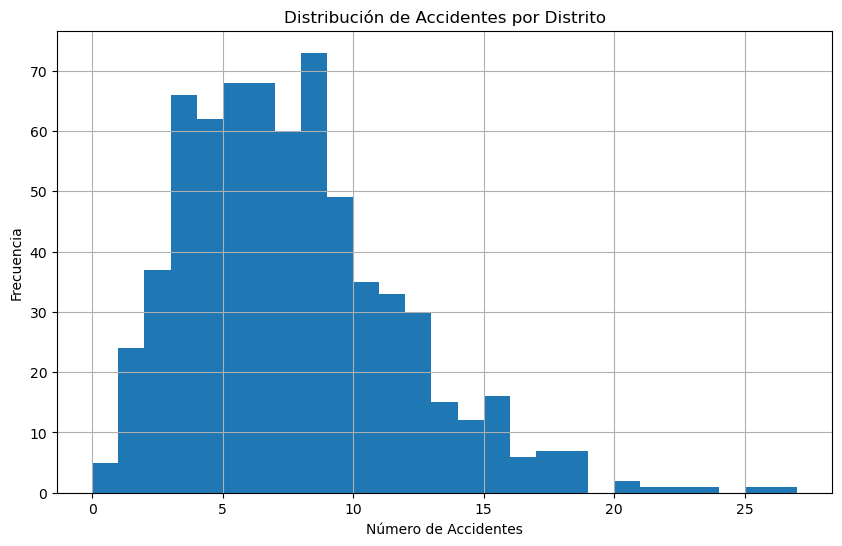

In [17]:
import matplotlib.pyplot as plt

#create histogram
london_wards['fire_count'].hist(bins=range(0, london_wards['fire_count'].max() + 2, 1), figsize=(10, 6))

plt.title('Distribución de Accidentes por Distrito')
plt.xlabel('Número de Accidentes')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [18]:
london_wards['fires_by_1000households']=london_wards['fire_count']/london_wards['households']*1000
london_wards.head(15)

,LAD24CD,geometry,WD24CD,WD24NM,LAD24NM,fire_count,households,fires_by_1000households
0,E09000001,"MULTIPOLYGON (((531663.092 180546.577, 531662....",E09000001,City of London,City of London,3,4914,0.610501
1,E09000030,"POLYGON ((536274.997 182418.503, 536260.304 18...",E05009317,Bethnal Green East,Tower Hamlets,14,7249,1.931301
2,E09000030,"POLYGON ((538733.449 178771.295, 538716.202 17...",E05009318,Blackwall & Cubitt Town,Tower Hamlets,15,9509,1.577453
3,E09000030,"POLYGON ((537638.7 184578.685, 537638.931 1845...",E05009319,Bow East,Tower Hamlets,18,8408,2.140818
4,E09000030,"POLYGON ((537375.704 182857.797, 537322.598 18...",E05009320,Bow West,Tower Hamlets,7,5279,1.326009
5,E09000030,"POLYGON ((538302.301 182600.76, 538299.342 182...",E05009321,Bromley North,Tower Hamlets,8,4523,1.768738
6,E09000030,"POLYGON ((538284.297 182426.806, 538282.422 18...",E05009322,Bromley South,Tower Hamlets,8,5050,1.584158
7,E09000030,"POLYGON ((538156.998 180588.696, 538160.601 18...",E05009323,Canary Wharf,Tower Hamlets,15,8559,1.752541
8,E09000030,"POLYGON ((537734.9 179037.9, 537752.297 179037...",E05009324,Island Gardens,Tower Hamlets,9,6139,1.466037
9,E09000030,"POLYGON ((538302.835 182337.988, 538301.55 182...",E05009325,Lansbury,Tower Hamlets,13,7529,1.726657


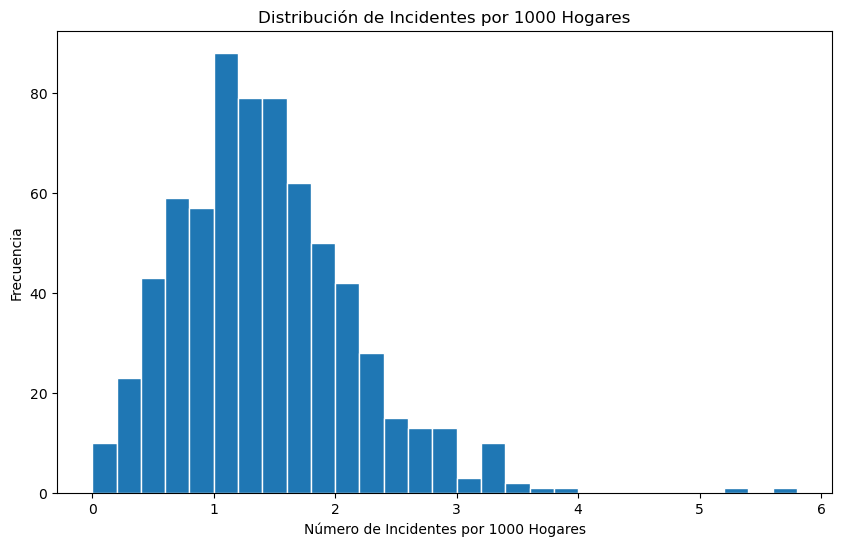

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#create histogram
london_wards['fires_by_1000households'].hist(bins=np.arange(0, london_wards['fires_by_1000households'].max() + 0.2, 0.2),
                                             figsize=(10, 6),
                                             edgecolor='white')

plt.title('Distribución de Incidentes por 1000 Hogares')
plt.xlabel('Número de Incidentes por 1000 Hogares')
plt.ylabel('Frecuencia')
plt.grid(False)
plt.show()

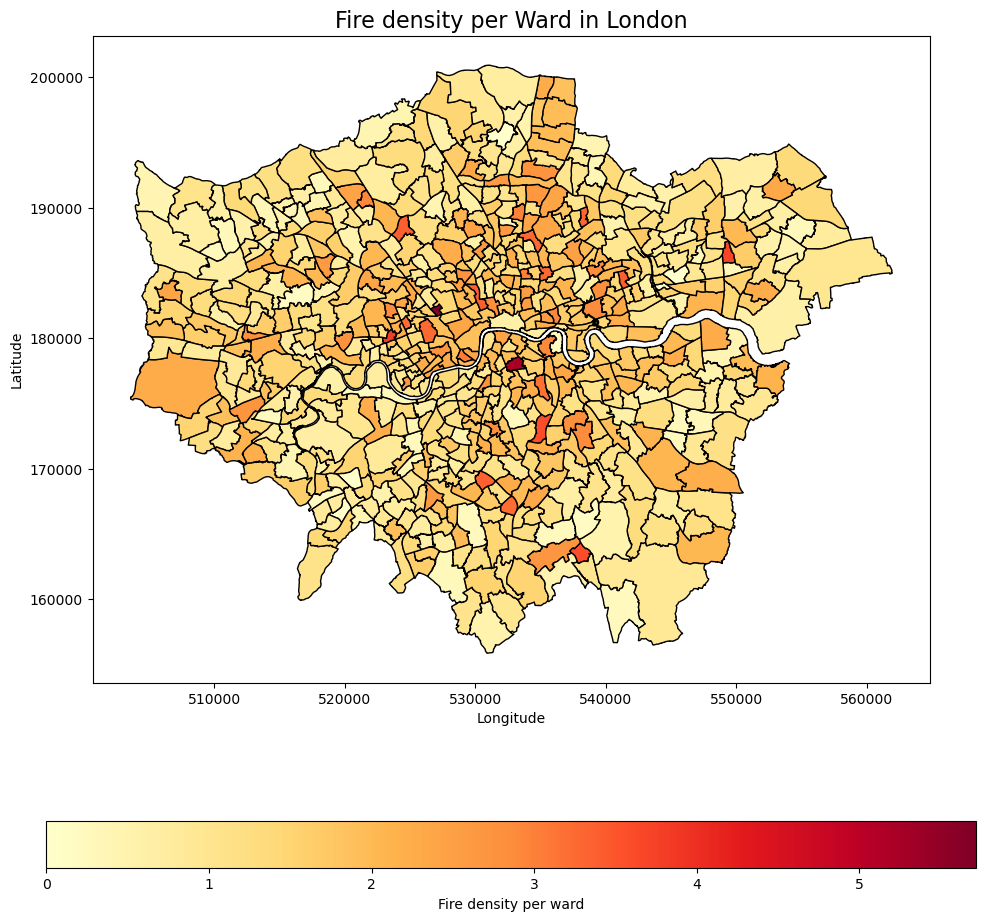

In [20]:
#Plot thematic map on fire incident density
fig, ax = plt.subplots(figsize=(12, 12))

#set thematic map
london_wards.plot(column='fires_by_1000households', ax=ax, legend=True,
           legend_kwds={'label': "Fire density per ward",
                        'orientation': "horizontal"},
           cmap='YlOrRd',  # Paleta de colores (amarillo a rojo)
           edgecolor='black')

plt.title("Fire density per Ward in London", fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

In [21]:
#Aggregate socio-economic information
pop_density=pd.read_csv("TS006-2021-3-filtered-2025-01-18T23_02_46Z.csv")

london_wards=london_wards.merge(pop_density, left_on='WD24CD', right_on='Electoral wards and divisions Code', how='left')

london_wards=london_wards.drop(['Electoral wards and divisions Code', 'Electoral wards and divisions'], axis=1)
london_wards.head()

london_wards=london_wards.rename(columns={'Observation':'pop_density'})
london_wards.head()

,LAD24CD,geometry,WD24CD,WD24NM,LAD24NM,fire_count,households,fires_by_1000households,pop_density
0,E09000001,"MULTIPOLYGON (((531663.092 180546.577, 531662....",E09000001,City of London,City of London,3,4914,0.610501,2975.0
1,E09000030,"POLYGON ((536274.997 182418.503, 536260.304 18...",E05009317,Bethnal Green East,Tower Hamlets,14,7249,1.931301,17378.0
2,E09000030,"POLYGON ((538733.449 178771.295, 538716.202 17...",E05009318,Blackwall & Cubitt Town,Tower Hamlets,15,9509,1.577453,15881.7
3,E09000030,"POLYGON ((537638.7 184578.685, 537638.931 1845...",E05009319,Bow East,Tower Hamlets,18,8408,2.140818,10472.5
4,E09000030,"POLYGON ((537375.704 182857.797, 537322.598 18...",E05009320,Bow West,Tower Hamlets,7,5279,1.326009,10203.2


In [22]:
#load deprivation data
deprivation = pd.read_csv("TS011-2021-2-filtered-2025-01-18T23_04_58Z.csv")

#Create a pivot table with deprivation options
pivot_table = deprivation.pivot_table(
    index='Electoral wards and divisions Code',  # Índice (ward code)
    columns='Household deprivation (6 categories) Code',  # Categorías de privación como columnas
    values='Observation',  # Valores numéricos (cantidad de hogares)
    aggfunc='sum',  # Agregación (suma para evitar duplicados)
    fill_value=0  # Rellenar NaN con 0
)

pivot_table.reset_index(inplace=True)

# Rename columns
pivot_table.rename(columns={
    -8: 'Not applicable',
    1: 'no_deprivation',
    2: '1d_deprivation',
    3: '2d_deprivation',
    4: '3d_deprivation',
    5: '4d_deprivation'
}, inplace=True)

#Merge with london wards df
london_wards = london_wards.merge(
    pivot_table,
    left_on='WD24CD',  # Columna en london_wards
    right_on='Electoral wards and divisions Code',  # Columna en pivot_table
    how='left'  # Left join
)

#check results
london_wards.head()

,LAD24CD,geometry,WD24CD,WD24NM,LAD24NM,fire_count,households,fires_by_1000households,pop_density,Electoral wards and divisions Code,Not applicable,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation
0,E09000001,"MULTIPOLYGON (((531663.092 180546.577, 531662....",E09000001,City of London,City of London,3,4914,0.610501,2975.0,E09000001,0,2937,1547,347,75,8
1,E09000030,"POLYGON ((536274.997 182418.503, 536260.304 18...",E05009317,Bethnal Green East,Tower Hamlets,14,7249,1.931301,17378.0,E05009317,0,2882,2483,1343,501,40
2,E09000030,"POLYGON ((538733.449 178771.295, 538716.202 17...",E05009318,Blackwall & Cubitt Town,Tower Hamlets,15,9509,1.577453,15881.7,E05009318,0,5293,2914,908,359,35
3,E09000030,"POLYGON ((537638.7 184578.685, 537638.931 1845...",E05009319,Bow East,Tower Hamlets,18,8408,2.140818,10472.5,E05009319,0,4222,2422,1277,447,39
4,E09000030,"POLYGON ((537375.704 182857.797, 537322.598 18...",E05009320,Bow West,Tower Hamlets,7,5279,1.326009,10203.2,E05009320,0,2385,1707,874,289,24


In [23]:
london_wards=london_wards.drop(['Electoral wards and divisions Code', 'Not applicable'],axis=1)

In [24]:
london_wards['deprived']=london_wards[['1d_deprivation','2d_deprivation','3d_deprivation','4d_deprivation']].sum(axis=1) 
london_wards.head()

,LAD24CD,geometry,WD24CD,WD24NM,LAD24NM,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation,deprived
0,E09000001,"MULTIPOLYGON (((531663.092 180546.577, 531662....",E09000001,City of London,City of London,3,4914,0.610501,2975.0,2937,1547,347,75,8,1977
1,E09000030,"POLYGON ((536274.997 182418.503, 536260.304 18...",E05009317,Bethnal Green East,Tower Hamlets,14,7249,1.931301,17378.0,2882,2483,1343,501,40,4367
2,E09000030,"POLYGON ((538733.449 178771.295, 538716.202 17...",E05009318,Blackwall & Cubitt Town,Tower Hamlets,15,9509,1.577453,15881.7,5293,2914,908,359,35,4216
3,E09000030,"POLYGON ((537638.7 184578.685, 537638.931 1845...",E05009319,Bow East,Tower Hamlets,18,8408,2.140818,10472.5,4222,2422,1277,447,39,4185
4,E09000030,"POLYGON ((537375.704 182857.797, 537322.598 18...",E05009320,Bow West,Tower Hamlets,7,5279,1.326009,10203.2,2385,1707,874,289,24,2894


In [25]:
ward_profile = pd.read_csv("ward-profiles-excel-version.csv", encoding='ISO-8859-1')
ward_profile.head()

,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,% All Children aged 0-15 - 2015,% All Working-age (16-64) - 2015,% All Older people aged 65+ - 2015,...,A-Level Average Point Score Per Student - 2013/14,A-Level Average Point Score Per Entry; 2013/14,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012
0,City of London,00AA,E09000001,8100.0,650.0,6250.0,1250.0,8.0,76.9,15.2,...,662.9,210.5,656.4,85.3,0.4,18.6,0.4,7.9,5.3,48.5
1,Barking and Dagenham - Abbey,00ABFX,E05000026,14750.0,3850.0,10150.0,750.0,26.0,69.0,5.0,...,682.6,208.9,138.1,42.2,1.4,21.9,0.5,6.0,0.8,25.7
2,Barking and Dagenham - Alibon,00ABFY,E05000027,10600.0,2700.0,6800.0,1050.0,25.7,64.3,10.0,...,627.9,201.6,73.6,27.3,0.7,20.6,0.8,3.1,1.0,20.3
3,Barking and Dagenham - Becontree,00ABFZ,E05000028,12700.0,3200.0,8350.0,1100.0,25.4,65.9,8.7,...,632.0,207.9,79.9,27.6,1.2,1.9,0.9,2.9,1.6,22.5
4,Barking and Dagenham - Chadwell Heath,00ABGA,E05000029,10400.0,2550.0,6400.0,1450.0,24.3,61.5,14.2,...,613.9,210.5,76.1,24.6,1.3,56.0,0.9,2.3,1.2,25.3


In [26]:
median_income=ward_profile[['New code','Median Household income estimate (2012/13)']]
median_income.head()

,New code,Median Household income estimate (2012/13)
0,E09000001,63620.0
1,E05000026,33920.0
2,E05000027,32470.0
3,E05000028,33000.0
4,E05000029,33920.0


In [27]:
london_wards=london_wards.merge(median_income, left_on='WD24CD', right_on='New code', how='left')


In [29]:
london_wards.head(50)

,LAD24CD,geometry,WD24CD,WD24NM,LAD24NM,fire_count,households,fires_by_1000households,pop_density,no_deprivation,1d_deprivation,2d_deprivation,3d_deprivation,4d_deprivation,deprived,New code,Median Household income estimate (2012/13)
0,E09000001,"MULTIPOLYGON (((531663.092 180546.577, 531662....",E09000001,City of London,City of London,3,4914,0.610501,2975.0,2937,1547,347,75,8,1977,E09000001,63620.0
1,E09000001,"MULTIPOLYGON (((531663.092 180546.577, 531662....",E09000001,City of London,City of London,3,4914,0.610501,2975.0,2937,1547,347,75,8,1977,E09000001,63620.0
2,E09000030,"POLYGON ((536274.997 182418.503, 536260.304 18...",E05009317,Bethnal Green East,Tower Hamlets,14,7249,1.931301,17378.0,2882,2483,1343,501,40,4367,NaN,NaN
3,E09000030,"POLYGON ((538733.449 178771.295, 538716.202 17...",E05009318,Blackwall & Cubitt Town,Tower Hamlets,15,9509,1.577453,15881.7,5293,2914,908,359,35,4216,NaN,NaN
4,E09000030,"POLYGON ((537638.7 184578.685, 537638.931 1845...",E05009319,Bow East,Tower Hamlets,18,8408,2.140818,10472.5,4222,2422,1277,447,39,4185,NaN,NaN
5,E09000030,"POLYGON ((537375.704 182857.797, 537322.598 18...",E05009320,Bow West,Tower Hamlets,7,5279,1.326009,10203.2,2385,1707,874,289,24,2894,NaN,NaN
6,E09000030,"POLYGON ((538302.301 182600.76, 538299.342 182...",E05009321,Bromley North,Tower Hamlets,8,4523,1.768738,19297.5,1826,1484,837,342,35,2698,NaN,NaN
7,E09000030,"POLYGON ((538284.297 182426.806, 538282.422 18...",E05009322,Bromley South,Tower Hamlets,8,5050,1.584158,20308.3,2149,1643,876,359,23,2901,NaN,NaN
8,E09000030,"POLYGON ((538156.998 180588.696, 538160.601 18...",E05009323,Canary Wharf,Tower Hamlets,15,8559,1.752541,12716.5,4996,2477,775,288,21,3561,NaN,NaN
9,E09000030,"POLYGON ((537734.9 179037.9, 537752.297 179037...",E05009324,Island Gardens,Tower Hamlets,9,6139,1.466037,14398.8,3113,1950,837,232,8,3027,NaN,NaN


In [ ]:

london_wards=london_wards.drop('New code', axis=1)
london_wards.head()

london_wards=london_wards.rename(columns={'Median Household income estimate (2012/13)':'median_income'})
london_wards.head()

In [ ]:
df = pd.read_excel(ukgranulargdhiothergeographies2002to2021.xlsx, sheet_name='Table 6')

# Filter only Gross Disposable Household Income rows
df_filtered = df[df['ColumnName'].str.contains('Gross Disposable Household Income', na=False)]

#Select useful columns
df_selected = df_filtered[['Ward code', 'Ward name', '2014']]

df_selected).head()